<a id='top'></a>

# Db2 11 Regular Expressions

Db2 11.1 introduced extended support for regular
expressions. Regular expressions allow you to do very complex
pattern matching in character strings. Normal SQL LIKE
searches are limited to very specific patterns, but Regular
expression have a rich syntax that gives you much more
flexibility in searching.

Set up the connection to the database and Db2 command extensions.

In [46]:
%run db2.ipynb

DB2 Extensions Loaded.


# Table of Contents

* [Sample Table Setup](#sample)
* [Regular Expression Commands](#regular)
* [Regular Expression Flags](#flags)
* [Regular Expression Search Patterns](#patterns)
* [Anchoring Patterns in a Search](#anchor)
* [Matching Patterns Across Lines](#multiple)
* [Logical OR Operator](#or)
* [Combining Patterns](#combine)
* [Matching Character Types](#chars)
* [Special Patterns](#special)
* [Negating Patterns](#negate)
* [Capturing Parenthesis](#capture)
* [Performance Considerations](#performance)

[Back to Top](#top)
<a id='sample'></a>

## Sample Table Setup

The following SQL will create a new table in the SAMPLE
database (or whatever database you are currently connected
to). This table represents all of the stations of the London
Underground Central line (existing stations only, not
historical ones!). This table will be used for all of the
examples within this section.

In [47]:
%%sql -q
DROP TABLE CENTRAL_LINE;

CREATE TABLE CENTRAL_LINE
  (
  STATION_NO INTEGER GENERATED ALWAYS AS IDENTITY,
  STATION VARCHAR(31),
  UPPER_STATION VARCHAR(31) GENERATED ALWAYS AS (UCASE(STATION))
  )
;

INSERT INTO CENTRAL_LINE(STATION)
  VALUES 'West Ruislip','Ruislip Gardens','South Ruislip','Northolt','Greenford',
         'Perivale','Hanger Lane','Ealing Broadway','West Acton','North Acton',
         'East Acton','White City','Shepherd''s Bush','Holland Park','Notting Hill Gate',
         'Queensway','Lancaster Gate','Marble Arch','Bond Street','Oxford Circus',
         'Tottenham Court Road','Holborn','Chancery Lane','St. Paul''s','Bank',
         'Liverpool Street','Bethnal Green','Mile End','Stratford','Leyton',
         'Leytonstone','Wanstead','Redbridge','Gants Hill','Newbury Park',
         'Barkingside','Fairlop','Hainault','Grange Hill','Chigwell',
         'Roding Valley','Snaresbrook','South Woodford','Woodford','Buckhurst Hill',
         'Loughton','Debden','Theydon Bois','Epping'
;

Connection successful.


[Back to Top](#top)
<a id='regular'></a>

# Regular Expression Commands


There are six regular expression functions within DB2
including:

- **REGEXP_COUNT** - Returns a count of the number of times that a regular expression pattern is matched in a string.
- **REGEXP_EXTRACT** - Returns one occurrence of a substring of a string that matches the regular expression pattern.
- **REGEXP_INSTR** - Returns the starting or ending position of the matched substring, depending on the value of the return option argument.
- **REGEXP_LIKE** - Returns a Boolean value indicating if the regular expression pattern is found in a string. The function can be used only where a predicate is supported.
- **REGEXP_MATCH_COUNT** - Returns a count of the number of times that a regular expression pattern is matched in a string.
- **REGEXP_REPLACE** - Returns a modified version of the source string where occurrences of the regular expression pattern found in the source string are replaced with the specified replacement string.
- **REGEXP_SUBSTR** - Returns one occurrence of a substring of a string that matches the regular expression pattern.

Each one of these functions follows a similar calling
sequence:
<pre> 
 REGEXP_FUNCTION(source, pattern, flags, start_pos, codeunits)
</pre>

The arguments to the function are:

- **Source** - string to be searched
- **Pattern** - the regular expression that contains what we are searching for
- **Flag** - settings that control how matching is done
- **Start_pos** - where to start in the string
- **Codeunits** - which type unit of measurement start_pos refers to (for Unicode)

The source can be any valid Db2 string including CHAR,
VARCHAR, CLOB, etc. Start_pos is the location in the source
string that you want to start searching from, and codeunits
tells Db2 whether to treat the start_pos as an absolute
location (think byte location) or a character location which
takes into account the unicode size of the character string.

Codeunits can be specified as CODEUNITS16, CODEUNITS32, or
OCTETS. CODEUNITS16 specifies that start is expressed in
16-bit UTF-16 code units. CODEUNITS32 specifies that start
is expressed in 32-bit UTF-32 code units. OCTETS specifies
that start is expressed in bytes.

Pattern and flag values are complex and so are discussed in
the following sections.

[Back to Top](#top)
<a id='flags'></a>

## Regular Express Flag Values
 
Regular expression functions have a flag specification that
can be used to change the behavior of the search. There are
six possible flags that can be specified as part of the
REGEXP command:

|Flag  |Purpose
|:----:|:--------------------
|**c** | Specifies that matching is case-sensitive (the default value)
|**i** | Specifies that matching is case insensitive
|**m** | Specifies that the input data can contain more than one line. By default, the '^' in a pattern matches only the start of the input string; the '\$' in a pattern matches only the end of the input string. If this flag is set, "^" and "\$" also matches at the start and end of each line within the input string.
|**n** | Specifies that the '.' character in a pattern matches a line terminator in the input string. By default, the '.' character in a pattern does not match a line terminator. A carriage-return and line-feed pair in the input string behaves as a single-line terminator, and matches a single "." in a pattern.
|**s** | Specifies that the '.' character in a pattern matches a line terminator in the input string. This value is a synonym for the 'n' value.
|**x** | Specifies that white space characters in a pattern are ignored, unless escaped.

[Back to Top](#top)
<a id='patterns'></a>

## Regular Expression Search Patterns

Regular expressions use certain characters to represent what
is matched in a string. The simplest pattern is a string by
itself.

In [48]:
%%sql
SELECT STATION FROM CENTRAL_LINE
  WHERE REGEXP_LIKE(STATION,'Ruislip')

,STATION
0,West Ruislip
1,Ruislip Gardens
2,South Ruislip


The pattern 'Ruislip' will look for a match of Ruislip
within the STATION column. Note that this pattern will also
match 'West Ruislip' or 'Ruislip Gardens' since we placed no
restriction on where the pattern can be found in the string.
The match will also be exact (case matters). This type of
search would be equivalent to using the SQL LIKE statement:

In [49]:
%%sql
SELECT STATION FROM CENTRAL_LINE
  WHERE STATION LIKE '%Ruislip%'

,STATION
0,West Ruislip
1,Ruislip Gardens
2,South Ruislip


If you didn't place the % at the beginning of the LIKE
string, only the stations that start with Ruislip would be
found.

In [50]:
%%sql
SELECT STATION FROM CENTRAL_LINE
  WHERE STATION LIKE 'Ruislip%'

,STATION
0,Ruislip Gardens


If you want to match Ruislip with upper or lower case being
ignored, you would add the 'i' flag as part of the
REGEXP_LIKE (or any REGEXP function).

In [51]:
%%sql
SELECT STATION FROM CENTRAL_LINE
  WHERE REGEXP_LIKE(STATION,'RUISLIP','i')

,STATION
0,West Ruislip
1,Ruislip Gardens
2,South Ruislip


[Back to Top](#top)
<a id='anchor'></a>

## Anchoring Patterns in a Search
 
By default a pattern will be matched anywhere in a string.
Our previous example showed how Ruislip could be found
anywhere in a string. To force a match to start at the
beginning of a string, the carat symbol ^ can be used to
force the match to occur at the beginning of a string.

In [52]:
%%sql
  SELECT STATION FROM CENTRAL_LINE
    WHERE REGEXP_LIKE(STATION,'^Ruislip')

,STATION
0,Ruislip Gardens


To match a pattern at the end of the string, the dollar sign
\$ can be used.

In [53]:
%%sql
  SELECT STATION FROM CENTRAL_LINE
    WHERE REGEXP_LIKE(STATION,'Ruislip$')

,STATION
0,West Ruislip
1,South Ruislip


To force an exact match with a string you would use both the
beginning and end anchors.

In [54]:
%%sql 
  SELECT STATION FROM CENTRAL_LINE
    WHERE REGEXP_LIKE(STATION,'^Leyton$')

,STATION
0,Leyton


Note that if we didn't use the end anchor, we are going to
get more than one result.

In [55]:
%%sql 
  SELECT STATION FROM CENTRAL_LINE
    WHERE REGEXP_LIKE(STATION,'^Leyton');

,STATION
0,Leyton
1,Leytonstone


[Back to Top](#top)
<a id='multiple'></a>

## Matching patterns across multiple lines

So far the examples have dealt with strings that do not
contain newline characters (or carriage feeds). In some
applications, data from an input panel may include multiple
lines which may contain hard line feeds. What this means is
that there are actually multiple lines in the data, but from
a database perspective, there is only one line in the
VARCHAR field. You can modify the behavior of the Regular
Expression search by instructing it to honor the CRLF
characters as line delimiters.

The following SQL will insert a single line with multiple
CRLF characters in it to simulate a multi-line text string.

In [56]:
%%sql -q
DROP TABLE LONGLINE;

CREATE TABLE LONGLINE (NAME VARCHAR(255));

INSERT INTO LONGLINE
  VALUES 'George' || CHR(10) || 'Katrina';

Searching for Katrina at the beginning and end of string
doesn't work.

In [57]:
%%sql
SELECT COUNT(*) FROM LONGLINE
  WHERE REGEXP_LIKE(NAME,'^Katrina$')

,1
0,0


We can override the regular expression search by telling it
to treat each NL/CRLF as the end of a string within a
string.

In [58]:
%%sql
SELECT COUNT(*) FROM LONGLINE
  WHERE REGEXP_LIKE(NAME,'^Katrina$','m')

,1
0,1


[Back to Top](#top)
<a id='or'></a>

## Logical OR Operator
 
Regular expressions can match more than one pattern. The OR
operator (|) is used to define alternative patterns that can
match in a string. The following example searches for
stations that have "ing" in their name as well as "hill".

In [59]:
%%sql
SELECT STATION FROM CENTRAL_LINE
  WHERE REGEXP_LIKE(STATION,'way|ing')

,STATION
0,Ealing Broadway
1,Notting Hill Gate
2,Queensway
3,Barkingside
4,Roding Valley
5,Epping


Some things to be aware of when creating the search pattern.
Spaces in the patterns themselves are significant. If the
previous search pattern had a space in one of the words, it
would not find it (unless of course there was a space in the
station name).

In [60]:
%%sql
SELECT STATION FROM CENTRAL_LINE
  WHERE REGEXP_LIKE(STATION,'way| ing') 

,STATION
0,Ealing Broadway
1,Queensway


Using the "x" flag will ignore blanks in your pattern, so
this would fix issues that we have in the previous example.

In [61]:
%%sql
SELECT STATION FROM CENTRAL_LINE
  WHERE REGEXP_LIKE(STATION,'way| ing','x')

,STATION
0,Ealing Broadway
1,Notting Hill Gate
2,Queensway
3,Barkingside
4,Roding Valley
5,Epping


Brackets can be used to make it clear what the pattern is
that you are searching for and avoid the problem of having
blanks in the expression. Brackets do have a specific usage
in regular expressions, but here we are using it only to
separate the two search strings.

In [62]:
%%sql
SELECT STATION FROM CENTRAL_LINE
  WHERE REGEXP_LIKE(STATION,'(way)|(ing)')

,STATION
0,Ealing Broadway
1,Notting Hill Gate
2,Queensway
3,Barkingside
4,Roding Valley
5,Epping


[Back to Top](#top)
<a id='combine'></a>

## Combining Patterns 
 
As we found out in the previous section, there is an OR
operator that you can use to select between two patterns.
How do you request that multiple patterns be present? First
we must understand how matching occurs when we have multiple
strings that need to be matched that have an unknown number
of characters between them.

For instance, how do we create a pattern that looks for
"ing" followed by "way" somewhere in the string? Regular
expression recognize the "." (period) character as matching
anything. Following the pattern you can add a modifier that
specifies how many times you want the pattern matched:

- **\*** - Match zero or more times
- **?** - Match zero or one times
- **+** - Match one or more times
- **{m}** - Match exactly m times
- **{m,}** - Match as least a minimum of m times
- **{m,n}** - Match at least a minimum of m times and no more than n times

The following regular expression searches for a pattern with
"ing" followed by any characters and then "way".


In [63]:
%%sql
SELECT STATION FROM CENTRAL_LINE
  WHERE REGEXP_LIKE(STATION,'(ing)*.(way)')

,STATION
0,Ealing Broadway
1,Queensway


The previous answer gave you two results (Ealing Broadway
and Queensway). Why two? The reason is that we used the \* in
the wrong place (a single character in a wrong place can
result in very different results!). What we really needed to
do was place a .\* after the (ing) to match "ing" and then
any characters, before matching "way". What our query did
above was match 0 or more occurences of "ing", followed by
any character, and then match "way". Here is the correct
query.

In [64]:
%%sql
SELECT STATION FROM CENTRAL_LINE
  WHERE REGEXP_LIKE(STATION,'(ing).*(way)')

,STATION
0,Ealing Broadway


Finding at least one occurrence of a pattern requires the
use of the + operator, or the bracket operators. This
example locates at least one occurrence of the "an" string
in station names.

In [65]:
%%sql
SELECT STATION FROM CENTRAL_LINE
  WHERE REGEXP_LIKE(STATION,'(an)+') 

,STATION
0,Hanger Lane
1,Holland Park
2,Lancaster Gate
3,Chancery Lane
4,Bank
5,Wanstead
6,Gants Hill
7,Grange Hill


If we want to find an exact number of occurrences, we need
to use the {} notation to tell the regular expression
matcher how many we want to find. The syntax of the {}
match is:

- **{m}** - Match exactly m times
- **{m,}** - Match as least a minimum of m times
- **{m,n}** - Match at least a minimum of m times and no more than n times

So the "+" symbol is equivalent to the following regular
expression using the {} syntax.

In [66]:
%%sql
SELECT STATION FROM CENTRAL_LINE
  WHERE REGEXP_LIKE(STATION,'(an){1,}')

,STATION
0,Hanger Lane
1,Holland Park
2,Lancaster Gate
3,Chancery Lane
4,Bank
5,Wanstead
6,Gants Hill
7,Grange Hill


If we want to match exactly 2 'an' patterns in a string, we
would think that changing the expression to {2} would work.

In [67]:
%%sql
SELECT STATION FROM CENTRAL_LINE
  WHERE REGEXP_LIKE(STATION,'(an){2}')

,STATION


Sadly, we get no results! This would appear to be the wrong
result, but it's because we got lucky with our first search!
The best way to figure out what we matched in the original
query is to use the REGEXP_EXTRACT and REGEXP_INSTR
functions.

- **REGEXP_EXTRACT** - Returns one occurrence of a substring of a string that matches the regular expression pattern.
- **REGEXP_INSTR** - Returns the starting or ending position of the matched substring, depending on the value of the return option argument.

The following SQL gives us a clue to what was found with the
(an) pattern.

In [68]:
%%sql
SELECT STATION,
   REGEXP_INSTR(STATION,'(an)') AS LOCATION,
   REGEXP_EXTRACT(STATION,'(an)') AS EXTRACT
FROM CENTRAL_LINE
   WHERE REGEXP_LIKE(STATION,'(an)')

,STATION,LOCATION,EXTRACT
0,Hanger Lane,2,an
1,Holland Park,5,an
2,Lancaster Gate,2,an
3,Chancery Lane,3,an
4,Bank,2,an
5,Wanstead,2,an
6,Gants Hill,2,an
7,Grange Hill,3,an


What you should see in the previous result is the location
where the "an" pattern was found in the string. Note that
all we matched was the "an" pattern, nothing else. So why
can't I find two "an" patterns in the string? The reason is
that (an){2} means "an" followed by another "an"! We didn't
tell the pattern to match anything else! What we need to do
is modify the pattern to say that it can match "an" followed
by anything else. The pattern needs to be modifed to (an).*
where the ".*" means any character following the "an".

In order to tell the regular expression function to use this
entire pattern (an).\* twice, we need to place brackets
around it as well. The final pattern is ((an).\*){2}.

In [69]:
%%sql
SELECT STATION FROM CENTRAL_LINE
  WHERE REGEXP_LIKE(STATION,'((an).*){2}')

,STATION
0,Hanger Lane
1,Chancery Lane


You should find that two stations match the pattern. The
following SQL shows which pattern is matched first in the
STATIONS names.

In [70]:
%%sql
SELECT STATION,
   REGEXP_INSTR(STATION,'((an).*){2}') AS LOCATION,
   REGEXP_EXTRACT(STATION,'((an).*){2}') AS EXTRACT
FROM CENTRAL_LINE
   WHERE REGEXP_LIKE(STATION,'((an).*){2}')

,STATION,LOCATION,EXTRACT
0,Hanger Lane,2,anger Lane
1,Chancery Lane,3,ancery Lane


[Back to Top](#top)
<a id='chars'></a>

## Matching character types 
 
Aside from matching entire strings, you can also use regular
expression to look for patterns of characters. The simplest
matching pattern is the period (.) which matches any
character. Matching a string of arbitrary length is the
pattern ".*". The "+" and "?" characters can also be used to
modify how many characters you want matched.

What about situations where you want to check for certain
patterns or characters in a string? A good example would be
a social security number, or credit card number. There are
certain patterns that you would find for these objects.
Assume we have a social security number in the format
xxx-xx-xxxx. It is possible to create a regular expression
that would return true if the SSN matched the pattern above
(it doesn't tell you if the SSN itself is valid, only that
it has the proper format).

Regular expressions allow you to create a list of characters
that need to be matched in something called a bracket
expression. A bracket expression has the format:

<pre> 
[a-z] [A-Z] [0-9] [a-zA-z]
</pre>

The examples above represent the following search patterns:

- **[a-z]** - match any series of lowercase characters between a and z
- **[A-Z]** - match any series of uppercase characters between A and Z
- **[0-9]** - match any valid digits
- **[a-zA-Z]** - match any lower- or uppercase letters

You can also enumerate all of the characters you want to
match by listing them between the brackets like
[abcdefghikjlmnopqrstuvwxyz]. The short form a-z is easier
to read and less prone to typing errors!

The following example checks for station names that start
with the letter P-R.

In [71]:
%%sql
SELECT STATION FROM CENTRAL_LINE
   WHERE REGEXP_LIKE(STATION,'^[P-R]')

,STATION
0,Ruislip Gardens
1,Perivale
2,Queensway
3,Redbridge
4,Roding Valley


If you wanted to include all stations that have the letter
P-R or p-e, you could add the condition within the brackets.

In [72]:
%%sql
SELECT STATION FROM CENTRAL_LINE
   WHERE REGEXP_LIKE(STATION,'[p-rP-R]')

,STATION
0,West Ruislip
1,Ruislip Gardens
2,South Ruislip
3,Northolt
4,Greenford
...,...
29,Snaresbrook
30,South Woodford
31,Woodford
32,Buckhurst Hill


Back to our SSN question. Can a regular expression pattern
be used to determine whether or not the string is in the
correct format? The data will be in the format XXX-XX-XXXX
so the regular expression needs to find the three numeric
values separated by dashes.

The number pattern can be represented with the bracket
expression [0-9]. To specify the number of characters that
need to be found, we use the braces {} to specify the exact
number required.

For the three numbers in the pattern we can use [0-9]{3},
[0-9]{2}, and [0-9]{4}. Adding in the dashes gives us the
final pattern. The SQL below checks to see if a SSN is
correct.

In [73]:
%%sql
VALUES
  CASE 
    WHEN REGEXP_LIKE('123-34-1422','[0-9]{3}-[0-9]{2}-[0-9]{4}') THEN 'Valid'
    ELSE 'Invalid'
  END

,1
0,Valid


The SSN is valid in the example above. Here are some other
examples to show whether or not the regular expression picks
up all of the errors.

In [74]:
%%sql
WITH SSNS(SSN) AS (
   VALUES 
      '123-34-1322',
      'ABC-34-9999',
      'X123-44-0001',
      '123X-Y44-Z0001',
      '111-222-111'
  )
SELECT SSN,
  CASE 
    WHEN REGEXP_LIKE(SSN,'[0-9]{3}-[0-9]{2}-[0-9]{4}') THEN 'Valid'
    ELSE 'Invalid'
  END
FROM SSNS

,SSN,2
0,123-34-1322,Valid
1,ABC-34-9999,Invalid
2,X123-44-0001,Valid
3,123X-Y44-Z0001,Invalid
4,111-222-111,Invalid


If you check closely, one of the strings was marked as
valid, although it is not correct (X123-44-0001). The reason
this occurred is that the pattern was found after the "X"
and it was correct. To prevent this from happening, we need
to anchor the pattern at the beginning to avoid this
situation. A better pattern would be to anchor both ends of
the pattern so there is no possibility of other characters
being at the beginning or end of the pattern.

In [75]:
%%sql
WITH SSNS(SSN) AS (
   VALUES 
      '123-34-1322',
      'ABC-34-9999',
      'X123-44-0001',
      '123X-Y44-Z0001',
      '111-222-111'
  )
SELECT SSN,
  CASE 
    WHEN REGEXP_LIKE(SSN,'^[0-9]{3}-[0-9]{2}-[0-9]{4}$') THEN 'Valid'
    ELSE 'Invalid'
  END
FROM SSNS

,SSN,2
0,123-34-1322,Valid
1,ABC-34-9999,Invalid
2,X123-44-0001,Invalid
3,123X-Y44-Z0001,Invalid
4,111-222-111,Invalid


[Back to Top](#top)
<a id='special'></a>

## Special Patterns 
 
The previous example used the [0-9] syntax to request that
only numbers be found in the pattern. There are some
predefined patterns that define these common patterns. The
first argument is Posix format (if it exists), the second is
the escape character equivalent, and the final one is the
raw pattern it represents.
 
|Posix      | Escape   | Pattern         | Meaning
|:----------| :--------| :---------------|:------------------------
|[:alnum:]  |          | [A-Za-z0-9]     | Alphanumeric characters
|		    | \w       | [A-Za-z0-9\_]    | Alphanumeric characters plus "\_"
|		    | \W       | [^A-Za-z0-9\_]   | Non-word characters
|[:alpha:]  | \a       | [A-Za-z]        | Alphabetic characters
|[:blank:]  | \s, \t   |                 | Space and tab
|		    | \b       |                 | Word boundaries
|[:cntrl:]  |          | [\x00-\x1F\x7F] | Control characters
|[:digit:]  | \d       | [0-9]           | Digits
|		    | \D       | [^0-9]          | Non-digits
|[:graph:]  |          | [\x21-\x7E]     | Visible characters
|[:lower:]  | \l       | [a-z]           | Lowercase letters
|[:print:]  | \p       | [\x20-\x7E]     | Visible characters and the space character
|[:punct:]  |          | [][!"#\$%&'()\*+,./:;<=>?@\^\_`{<code>&#124;</code>}~-] | Punctuation characters
|[:space:]  | \s       | [ \t\r\n\v\f]   | Whitespace characters
|		    | \S       | [^ \t\r\n\v\f]  | Non-whitespace characters
|[:upper:]  | \u       | [A-Z]           | Uppercase letters
|[:xdigit:] | \x       | [A-Fa-f0-9]     | Hexadecimal digits

For instance, the following three statements will produce
the same result.

In [76]:
%%sql
WITH SSNS(SSN) AS (
   VALUES 
      '123-34-1322',
      'ABC-34-9999',
      'X123-44-0001',
      '123X-Y44-Z0001',
      '111-222-111'
  )
SELECT 'Original', SSN,
  CASE 
    WHEN REGEXP_LIKE(SSN,'^[0-9]{3}-[0-9]{2}-[0-9]{4}$') THEN 'Valid'
    ELSE 'Invalid'
  END
FROM SSNS
UNION ALL
SELECT 'Posix', SSN,
  CASE 
    WHEN REGEXP_LIKE(SSN,'^[:digit:]{3}-[:digit:]{2}-[:digit:]{4}$') THEN 'Valid'
    ELSE 'Invalid'
  END
FROM SSNS
UNION ALL
SELECT 'Escape', SSN,
  CASE 
    WHEN REGEXP_LIKE(SSN,'^\d{3}-\d{2}-\d{4}$') THEN 'Valid'
    ELSE 'Invalid'
  END
FROM SSNS

,1,SSN,3
0,Original,123-34-1322,Valid
1,Original,ABC-34-9999,Invalid
2,Original,X123-44-0001,Invalid
3,Original,123X-Y44-Z0001,Invalid
4,Original,111-222-111,Invalid
...,...,...,...
10,Escape,123-34-1322,Valid
11,Escape,ABC-34-9999,Invalid
12,Escape,X123-44-0001,Invalid
13,Escape,123X-Y44-Z0001,Invalid


[Back to Top](#top)
<a id='negate'></a>

## Negating Patterns 
 
Up to this point in time, the patterns that have been used
are looking for a positive match. In some cases you may want
to find values that do not match. The easiest way is to
negate the actual REGEXP_LIKE expression. The following
expression finds all of the stations that start with "West".

In [77]:
%%sql
SELECT STATION FROM CENTRAL_LINE
  WHERE REGEXP_LIKE(STATION,'^West')

,STATION
0,West Ruislip
1,West Acton


Adding the NOT modifier in front of the REGEXP function
gives us the stations that do not begin with West.

In [78]:
%%sql
SELECT STATION FROM CENTRAL_LINE
  WHERE NOT REGEXP_LIKE(STATION,'^West') 

,STATION
0,Ruislip Gardens
1,South Ruislip
2,Northolt
3,Greenford
4,Perivale
...,...
42,Buckhurst Hill
43,Loughton
44,Debden
45,Theydon Bois


You can also negate some of the searches in a pattern by
using the [^...] syntax where the ^ tells the regular
expression not to match the following characters. The
expression [^0-9] would mean match any characters which are
not numeric.

However, regular expressions have something called negative
lookarounds which basically mean find the pattern which does
not match. You create this pattern by adding the (?!..) at
the beginning of the string. The same query (finding
stations that don't start with West) would be written with
this lookaround logic found in the SQL below.

In [79]:
%%sql
SELECT STATION FROM CENTRAL_LINE
  WHERE REGEXP_LIKE(STATION,'^(?!West)')

,STATION
0,Ruislip Gardens
1,South Ruislip
2,Northolt
3,Greenford
4,Perivale
...,...
42,Buckhurst Hill
43,Loughton
44,Debden
45,Theydon Bois


[Back to Top](#top)
<a id='capture'></a>

## Capturing Parenthesis 
 
The previous example used something called a negative
lookaround with capturing parenthesis. When you place a
pattern within a set of brackets (...) the string that
matches this pattern is "remembered". The strings that are
matched can be used in subsequent parts of your regular
expression. This allows a form of programming within your
regular expression!

Each set of parentheses that are matched are associated with
a number, starting at one and incrementing for each
subsequent pattern match. For instance, the following
pattern will have three matches:
<pre>
^([0-9]{3})-([0-9]{3})-([0-9]{3})$
</pre>
This is similar to the SSN example used earlier on in this
section. The difference in this example is that each block
of numbers is exactly the same (3 digits). This pattern will
match any sequence of numbers in the format 123-456-789.

In [80]:
%%sql
WITH SSNS(SSN) AS (
   VALUES 
      '123-456-789',
      '123-555-123',
      '890-533-098',
      '123-456-456'
  )
SELECT SSN,
  CASE 
    WHEN REGEXP_LIKE(SSN,'^([0-9]{3})-([0-9]{3})-([0-9]{3})$') THEN 'Valid'
    ELSE 'Invalid'
  END
FROM SSNS

,SSN,2
0,123-456-789,Valid
1,123-555-123,Valid
2,890-533-098,Valid
3,123-456-456,Valid


All of these numbers fit the pattern and should be valid.
When one of the capturing parenthesis matches, it will
remember the string that it matched. For instance, in the
first example (123-456-789), the first match will find the
string '123'. The second match will find '456' and so on. We
can refer to these matched strings with the special control
characters \n where n represents the capturing parenthesis
location. So \1 would refer to the '123' that was found. \2
would be for '456'.

The regular expression will be updated so that the last part
of the pattern needs to be numeric (0-9) but can't be same
as the first match.

In [81]:
%%sql
WITH SSNS(SSN) AS (
   VALUES 
      '123-456-789',
      '123-555-123',
      '890-533-098',
      '123-456-456'
  )
SELECT SSN,
  CASE 
    WHEN REGEXP_LIKE(SSN,'^([0-9]{3})-([0-9]{3})-(?!\1)([0-9]{3})$') THEN 'Valid'
    ELSE 'Invalid'
  END
FROM SSNS

,SSN,2
0,123-456-789,Valid
1,123-555-123,Invalid
2,890-533-098,Valid
3,123-456-456,Valid


In many cases it may be easier to find the patterns that
match and then negate the REGEXP statement! The (?...)
syntax is used for a variety of purposes in regular
expressions:

| Pattern   | Result
|:----------| :-----------
| (?: ... ) | Non-capturing parentheses. Groups the included pattern, but does not provide capturing of matching text. More efficient than capturing parentheses.
| (?> ... ) | Atomic-match parentheses. First match of the parenthesized subexpression is the only one tried. If it does not lead to an overall pattern match, back up the search for a match to a position before the "(?>"
| (?# ... ) | Free-format comment (?# comment )
| (?= ... ) | Look-ahead assertion. True if the parenthesized pattern matches at the current input position, but does not advance the input position.
| (?! ... ) | Negative look-ahead assertion. True if the parenthesized pattern does not match at the current input position. Does not advance the input position.
| (?<= ... )| Look-behind assertion. True if the parenthesized pattern matches text that precedes the current input position. The last character of the match is the input character just before the current position. Does not alter the input position. The length of possible strings that is matched by the look-behind pattern must not be unbounded (no * or + operators.)
| (?<!... ) | Negative Look-behind assertion. True if the parenthesized pattern does not match text that precedes preceding the current input position. The last character of the match is the input character just before the current position. Does not alter the input position. The length of possible strings that is matched by the look-behind pattern must not be unbounded (no * or + operators.)


For efficiency in matching, the best approach is to place
strings that you are searching for in non-capturing
parentheses (?:...) rather than the generic () parenthesis.
The following example finds all stations with "West" in the
name.

In [82]:
%%sql 
SELECT STATION FROM CENTRAL_LINE
  WHERE REGEXP_LIKE(STATION,'(West)')

,STATION
0,West Ruislip
1,West Acton


The following SQL is equivalent, except that the matched
pattern is not kept for future use in matching.

In [83]:
%%sql
SELECT STATION FROM CENTRAL_LINE
  WHERE REGEXP_LIKE(STATION,'(?:West)')

,STATION
0,West Ruislip
1,West Acton


[Back to Top](#top)
<a id='performance'></a>

## Performance Considerations of Regular Expressions 
 
We know that there are better ways to write Regular
Expressions (like the use of non-capturing parenthesis. How
much of a difference does this make? In order to find out,
the following SQL will take the existing table and insert
into a temporary table 1000 times (for close to 50000
records). 

This SQL will generate the new table and fill it with the
base CENTRAL_LINE data.

In [84]:
%%sql -d -q
DROP TABLE TEMP_LINE
@

CREATE TABLE TEMP_LINE AS (SELECT * FROM CENTRAL_LINE) DEFINITION ONLY NOT LOGGED INITIALLY
@
 
BEGIN
   DECLARE I INTEGER DEFAULT 0;   
   WHILE I <= 1000 DO
      INSERT INTO TEMP_LINE SELECT * FROM CENTRAL_LINE;
      SET I = I + 1;
   END WHILE;
END
@

SELECT COUNT(*) FROM TEMP_LINE
@

,1
0,49049


We will run four queries in the following SQL.

 - Search for West using the LIKE statement 
 - Search for West using a regular expression with no matching () 
 - Search for West using a regular expression with matching ()
 - Search for West using a regular expression with non-capturing parenthesis (?:)

The queries are run as many times as possible per second to get consistent results. Odds are that there will be variations in the results on your system!

In [85]:
results_like         = %sql -t SELECT COUNT(*) FROM TEMP_LINE WHERE STATION LIKE '%West%'
results_string       = %sql -t SELECT COUNT(*) FROM TEMP_LINE WHERE REGEXP_LIKE(STATION,'West')
results_capturing    = %sql -t SELECT COUNT(*) FROM TEMP_LINE WHERE REGEXP_LIKE(STATION,'(West)')
results_noncapturing = %sql -t SELECT COUNT(*) FROM TEMP_LINE WHERE REGEXP_LIKE(STATION,'(?:West)')

Total iterations in 1 second(s): 168
Total iterations in 1 second(s): 27
Total iterations in 1 second(s): 26
Total iterations in 1 second(s): 27


The results are placed into a temporary table for easier formatting.

In [86]:
%sql -q DROP TABLE RESULTS
%sql CREATE TABLE RESULTS(TYPE VARCHAR(16), RESULT DEC(9,2))
%sql INSERT INTO RESULTS VALUES ('LIKE', {results_like} ), \
  ('REGX STRING', {results_string} ), \
  ('REGX CAPTURE', {results_capturing} ), \
  ('REGX NONCAPTURE', {results_noncapturing} )
%sql SELECT * FROM RESULTS

Command completed.
Command completed.


,TYPE,RESULT
0,LIKE,168.0
1,REGX STRING,27.0
2,REGX CAPTURE,26.0
3,REGX NONCAPTURE,27.0


The results are clearer when we plot them all on one graph!

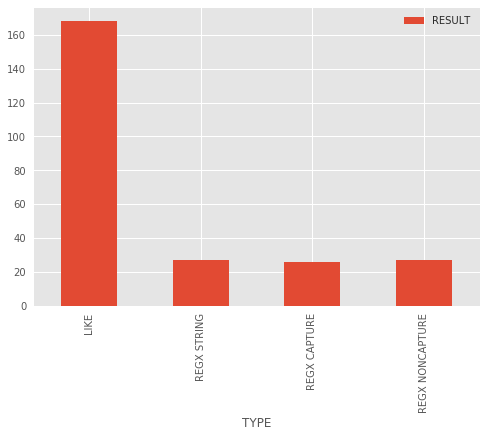

In [87]:
%sql -pb SELECT * FROM RESULTS

Every system will have different performance
characteristics, but the odds are that the LIKE statement
was faster than the regular expression. The performance is
probably ranked this way (with tx/sec being the measurement):

<pre>
LIKE > REGEXP(Non-capturing) > REGEXP(Capturing) > REGEXP(String) 
</pre>

However, your system will probably get different results. So
while Regular expressions are very powerful, there is a
performance penalty when using them. In addition, you may
need to consider the use of indexes from a performance
perspective.

The following SQL will add an index to the STATION name.

In [88]:
%%sql -q
DROP INDEX TEMP_STATION_INDEX;
CREATE INDEX TEMP_STATION_INDEX ON TEMP_LINE(STATION);

We will try the 4 queries again and plot the result.

Total iterations in 1 second(s): 180
Total iterations in 1 second(s): 292
Total iterations in 1 second(s): 280
Total iterations in 1 second(s): 275


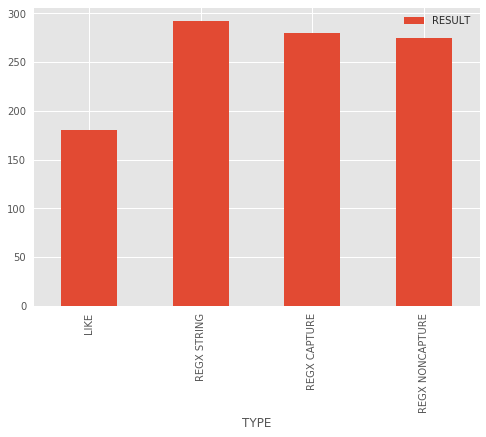

In [89]:
results_like         = %sql -t SELECT COUNT(*) FROM TEMP_LINE WHERE STATION LIKE '%West%'
results_string       = %sql -t SELECT COUNT(*) FROM TEMP_LINE WHERE REGEXP_LIKE(STATION,'West')
results_capturing    = %sql -t SELECT COUNT(*) FROM TEMP_LINE WHERE REGEXP_LIKE(STATION,'(West)')
results_noncapturing = %sql -t SELECT COUNT(*) FROM TEMP_LINE WHERE REGEXP_LIKE(STATION,'(?:West)')
%sql -q DROP TABLE RESULTS
%sql -q CREATE TABLE RESULTS(TYPE VARCHAR(16), RESULT DEC(9,2))
%sql -q INSERT INTO RESULTS VALUES ('LIKE', {results_like} ), \
  ('REGX STRING', {results_string} ), \
  ('REGX CAPTURE', {results_capturing} ), \
  ('REGX NONCAPTURE', {results_noncapturing} )
%sql SELECT * FROM RESULTS
%sql -pb SELECT * FROM RESULTS

The index can help speed up processing of the LIKE statement and the regular expression calls. The results may or may not favor LIKE over regular expressions. In summary, if you are going to use regular expressions, you may get a performance advantage by using indexes if possible.

[Back to Top](#top)

#### Credits: IBM 2018, George Baklarz [baklarz@ca.ibm.com]